# Markov chains for gradient estimation in the context of Restricted Boltzman Machine Learning

_Authors: Alan García and Sandra Burgos_

notebook explanation...

## Packages

In [1]:
# Main packages for the implementation
import gzip
import numpy as np
from abc import ABC, abstractmethod

# Just for working with datasets
from sklearn.model_selection import train_test_split
from sklearn.utils import gen_batches

# For plotting
import matplotlib.pyplot as plt

In [8]:
np.random.seed(42) # For reproducibility

## Datasets

For the development and testing of the RBM implementations the MNIST handwritten numbers dataset has been used...

In [3]:
class MNIST:
    """
    https://yann.lecun.com/exdb/mnist/
    ubyte format of MNIST images:
        [offset] [type]          [value]          [description]
        0000     32 bit integer  0x00000803(2051) magic number
        0004     32 bit integer  10000            number of images
        0008     32 bit integer  28               number of rows
        0012     32 bit integer  28               number of columns
        0016     unsigned byte   ??               pixel
        0017     unsigned byte   ??               pixel
        ........
        xxxx     unsigned byte   ??               pixel
    
    ubyte format of MNIST labels:
        [offset] [type]          [value]          [description]
        0000     32 bit integer  0x00000801(2049) magic number (MSB first)
        0004     32 bit integer  60000            number of items
        0008     unsigned byte   ??               label
        0009     unsigned byte   ??               label
        ........
        xxxx     unsigned byte   ??               label
    """
    
    def __init__(self, images_path: str, label_path: str, N: int = None) -> None:
        """
            INPUT:
                - images path: path of the dataset images
                - labels path: path of the dataset labels
                - N: if not provided, all the images in the input file are read.
                    Else, N images are read.
        """
        
        self.images_path = images_path
        self.labels_path = label_path

        # Open with gzip to uncompress the files
        self.images_file = gzip.open(self.images_path, "rb")
        self.labels_file = gzip.open(self.labels_path, "rb")
        self.images_file.read(4) # Ignore the magic numbers
        self.labels_file.read(4)

        # Prepare Images data file reader
        self.number_of_items = int.from_bytes(self.images_file.read(4), byteorder="big") # Total number of images
        self.row_num = int.from_bytes(self.images_file.read(4), byteorder="big")    # row pixels of image
        self.col_num = int.from_bytes(self.images_file.read(4), byteorder="big")    # col pixels of image
        
        self.N = self.number_of_items if N is None else N # Number of items to be read
        self.num_bytes_per_image = self.col_num * self.row_num
        self.returned_images = 0    # Number of read images
        self.images_file.seek(16)   # Set the cursor to the init of the first image

        # Prepare Labels file reader
        assert self.number_of_items == int.from_bytes(self.labels_file.read(4), byteorder="big")
        self.labels_file.seek(8)

        # Print metadata
        print(f"[MNIST]     image size: {self.col_num}x{self.row_num} total dataset images: {self.number_of_items} images to be read: {self.N}")

        

    def __iter__(self):
        """Create an iterator for the MNIST dataset"""
        return self

    def __next__(self):
        """Return the next image in the dataset"""
        if self.returned_images >= self.N:
            self.images_file.close()
            self.labels_file.close()
            raise StopIteration
        else:
            pixels = []
            for _ in range(self.num_bytes_per_image):
                data = self.images_file.read(1)

                if not data:
                    print(f"[MNIST]     ERROR -> This should not be reached")
                    self.file.close()
                    raise StopIteration
                
                pixels.append(int.from_bytes(data, byteorder="big"))
            label = int.from_bytes(self.labels_file.read(1))
            self.returned_images += 1

            pixels = np.array(pixels)
            pixels = pixels / 255 # Normalize data 
            pixels = np.where(pixels > 0.5, 1, 0) # Transform to binary
            return pixels.tolist(), label

    def __del__(self):
        # Close the files if the object is destroyed
        if hasattr(self, 'images_file') and not self.images_file.closed:
            self.images_file.close()
        if hasattr(self, 'labels_file') and not self.labels_file.closed:
            self.labels_file.close()

    def to_list(self):
        return list(self)
    
    def to_numpy(self):
        dataset = self.to_list()
        X = np.array([item[0] for item in dataset])
        Y = np.array([item[1] for item in dataset])
        return X, Y

The `MNIST` class is just a helper to load the encoded MNIST Dataset from the `./data/` folder....

[MNIST]     image size: 28x28 total dataset images: 10000 images to be read: 10


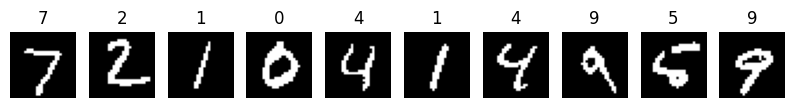

In [4]:
def MNIST_test():
    # Read the 10 first images from the MNIST dataset
    dataset = MNIST("./data/t10k-images-idx3-ubyte.gz", "./data/t10k-labels-idx1-ubyte.gz", 10)

    # Iterate the dataset
    images = []
    for img, label in dataset:
        images.append((img, label))

    # Show the result
    import matplotlib.pyplot as plt
    import numpy as np
    fig, axes = plt.subplots(1, len(images), figsize=(10, 2))
    for i in range(len(images)):
        img = np.array(images[i][0]).reshape(28, 28)
        axes[i].set_title(f"{images[i][1]}")
        axes[i].imshow(img, cmap="gray")  # Redimensiona cada imagen a 28x28
        axes[i].axis("off")  # Oculta los ejes

    plt.show()

MNIST_test()

## RBM Base

This is the main class of our implementation...

In [6]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def kl_divergence(p, q):
    """
    The KL-Divergence measures how different are two probability distributions
    over the same variable. 
    """ 
    assert len(p) == len(q)
    q[q == 0] = 0.00000001 # Not let any element of q be 0
    return sum(p[i] * np.log2(p[i] / q[i]) for i in range(len(p)) if p[i] > 0)

In [7]:
class RBM(ABC):
    """
        Implementation of Restricted Boltzman Machine for
        KISA Optimization Techniques by Sandra Burgos and
        Alan Garcia.
        
        References:
            - https://es.wikipedia.org/wiki/M%C3%A1quina_de_Boltzmann_restringida
            - https://upcommons.upc.edu/bitstream/handle/2117/344139/TFM.pdf?sequence=2&isAllowed=y

        Other resources for implementation:
            1. https://leftasexercise.com/2018/04/09/restricted-boltzmann-machines/
            2. https://leftasexercise.com/2018/04/13/learning-algorithms-for-restricted-boltzmann-machines-contrastive-divergence/
            3. https://leftasexercise.com/2018/04/20/training-restricted-boltzmann-machines-with-persistent-contrastive-divergence/ 
            4. https://christian-igel.github.io/paper/TRBMAI.pdf
    """
    def __init__(self, visible_nodes, hidden_nodes, k: int = 1) -> None:
        """
            n_v: number of visible nodes
            n_h: number of hidden nodes
            k -> Number of gibbsampling steps to be performed    

            W -> Network weights
            a -> Visible layer biases
            b -> Hidden layer biases
        """
        
        self.n_v = visible_nodes
        self.n_h = hidden_nodes
        self.k = k 

        # Initialize random weights from uniform distribution (Xavier initialization)
        limit = np.sqrt(6. / (self.n_v + self.n_h))
        self.W = np.random.uniform(low=-limit, high=limit, size=(self.n_v, self.n_h))
        self.a = np.random.uniform(low=-limit, high=limit, size=(self.n_v)) # np.zeros((1, visible_nodes))
        self.b = np.random.uniform(low=-limit, high=limit, size=(self.n_h)) # np.zeros((1, hidden_nodes))
    
    def _forward(self, V):
        """ 
            Fordward propagation:
            Activation probability 
                > P(hj = 1 | v) = S (bj + sum_i=1^m(Wi,j * vi) )
                    where S is the sigmoid function, v the visible layers set and h the hidden layers set
                > P(h | v) = S( b + v @ W)
        """
        # V: (N, visible_nodes)
        h_p = np.dot(V, self.W) + self.b
        h_p = sigmoid(h_p)
        assert h_p.shape == (V.shape[0], self.n_h)

        h = np.random.binomial(1, h_p, size=h_p.shape)
        return h_p, h
    
    def _backward(self, H):
        """
            Backward:
            Activation probability > P(vi = 1 | h) = S (ai + sum_j=1^m(Wi,j * hj) )
                where S is the sigmoid function, v the visible layers set and h the hidden layers set
        """
        # V: (N, hidden_nodes)
        v_p = np.dot(H, self.W.T) + self.a
        v_p = sigmoid(v_p)
        assert v_p.shape == (H.shape[0], self.n_v)

        v = np.random.binomial(1, v_p, size=v_p.shape)
        return v_p, v

    def _gibbsampling(self, V):
        """
            Perform Gibbsampling
            OUTPUT: (h_p, h, v_p_, v_)
                h_p: hidden layer activation probs
                h: hidden layer samples
                v_p_: visible layer activation probs
                v_: visible layer reconstruction
        """
        v = V
        for i in range(self.k):
            h_p, h = self._forward(v)
            v_p, v = self._backward(h)
        return h_p, h, v_p, v

    @abstractmethod
    def fit():
        """
        The objective is to minimize the energy E of the system:
            E(v, h)=-a' v - b' h - v' W h
        So, to train the RBM we need to compute these terms:
            ∂Energy(v, h)/∂Wij = −hi · vj
            ∂Energy(v, h)/∂bj = −vj
            ∂Energy(v, h)/∂ci = −hi
        However, we don't have access to v and h but we have access
        to ther probabilities p_v and p_h, so we have to sample from
        P(v | h) and P(h | v)
        But direct sampling from those distributions is hard, thats why 
        CD, PCD and other methods were developed
        """
        raise NotImplemented

    def reconstruct(self, X):
        """
            Gibbsampling step to reconstruct output vk from v0 input.
            OUTPUT: generated visible layer output
        """
        h_p, h, v_p_, v_  = self._gibbsampling(X)
        return v_

In [9]:
# Example data input
v = np.array([
    [0.001, 1, 0.001, 1]
    ])

# Instantiate the RBM test object
class RBM_BASE(RBM):
    def __init__(self, visible_nodes, hidden_nodes):
        super().__init__(visible_nodes, hidden_nodes)
    def fit():
        # Train not implemented for just testing 
        # the vissible and hidden layers
        pass
rbm = RBM_BASE(4, 2)
p_h, h = rbm._forward(v)

print("RBM BASE TEST")
print(f"Test input shape: {v.shape} Test input: \n{v}")
print(f"rbm visible nodes: {rbm.n_v} hidden nodes: {rbm.n_v}")
print(f"rbm.a biasses shape: {rbm.a.shape} rbm.a biasses: \n{rbm.a}")
print(f"rbm.b biasses shape: {rbm.b.shape} rbm.b biasses: \n{rbm.b}")
print(f"rbm.W weights shape: {rbm.W.shape} rbm.W weights: \n{rbm.W}")
print(f"rbm forward shape{p_h.shape} rbm forward out: \n{p_h}")

p_v, v = rbm._backward(p_h)
print(f"rbm backward shape{p_v.shape} rbm backward out: \n{p_v}")

v_ = rbm.reconstruct(v)
print(f"rbm reconstruct process for v input and {rbm.k} gibbsampling steps: \n{v_}")
    
# The goal is to reduce the divergence between the input probability
# dsitribution and the output. 
# v = np.array([1, 0.001, 0.001, 1])
# v_ = np.array([1, 1, 1, 1])
# kld = 0.98860 >> 0 -> significant divergence
kld = kl_divergence(v.flatten() / np.sum(v.flatten()), v_.flatten() / np.sum(v_.flatten()))
print(f"KL-Divergence between input and final RBM probability output: {kld}")
print("===================================")
print()

RBM BASE TEST
Test input shape: (1, 4) Test input: 
[[0.001 1.    0.001 1.   ]]
rbm visible nodes: 4 hidden nodes: 4
rbm.a biasses shape: (4,) rbm.a biasses: 
[ 0.20223002  0.41614516 -0.95883101  0.9398197 ]
rbm.b biasses shape: (2,) rbm.b biasses: 
[ 0.66488528 -0.57532178]
rbm.W weights shape: (4, 2) rbm.W weights: 
[[-0.25091976  0.90142861]
 [ 0.46398788  0.19731697]
 [-0.68796272 -0.68801096]
 [-0.88383278  0.73235229]]
rbm forward shape(1, 2) rbm forward out: 
[[0.56072415 0.58772315]]
rbm backward shape(1, 4) rbm backward out: 
[[0.64366881 0.68832114 0.1481799  0.70571312]]
rbm reconstruct process for v input and 1 gibbsampling steps: 
[[1 1 0 0]]
KL-Divergence between input and final RBM probability output: 7.940179085645143



## RBM Contrastive Divergence

Here it is the implementation of the Contrastive Divergence algorithm for training Restricted Boltzman Machines...

## RBM Persistent Contrastive Divergence

Here it is the implementation of the Persisten Contrastive Divergence algorithm...